In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
import os
import seaborn as sns
from scipy import stats
import sys
sys.path.append('..')
from madule import simulation
from madule import plots
from statsmodels.stats.anova import AnovaRM
from scipy.io import loadmat

In [3]:
# Read original action first and color first task design to get reward schedule
dataActFirst = loadmat('/mnt/projects/7TPD/bids/derivatives/fMRI_DA/data_BehModel/predefined-task-values/ExpStruct_ActFirst_winOnly.mat')  
dataClrFirst = loadmat('/mnt/projects/7TPD/bids/derivatives/fMRI_DA/data_BehModel/predefined-task-values/ExpStruct_StimFirst_winOnly.mat')  

# read collected data across data
behAll = pd.read_csv('/mnt/projects/7TPD/bids/derivatives/fMRI_DA/data_BehModel/originalfMRIbehFiles/AllBehData/behAll.csv')
# rearrange trial number
behAll['trialNumber'].replace(
       [44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
        58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85],
       [2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
        30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43], inplace=True)

### staty on rewarded trials

In [4]:
# Create empty dataframe to save proportion win stay and lose shift for each record
df_win_loss = pd.DataFrame()

# List of subjects
subList = np.unique(behAll.sub_ID)
for sub in subList:
    for session in range(2):
        for run in range(2):
            for block in ['Act', 'Stim']:
                
                # Take color or action value learning, one  
                behAllCond = behAll.loc[(behAll['session']==session+1)&(behAll['run']==run+1)&(behAll['block']==block)&(behAll['sub_ID']==sub)]
                # get reverse
                reverse = np.unique(behAllCond.reverse)[0]
                # get group label
                group = np.unique(behAllCond.group)[0]
                
                # number of winning reward for action value learning
                n_win = np.sum(behAllCond['correctChoice'].to_numpy()==1)
                win_stay = np.zeros(n_win)
                if block=='Act':
                    j = 0
                    for i in range(len(behAllCond)-1):
                        if behAllCond['correctChoice'].to_numpy()[i]==1:
                            win_stay[j] = behAllCond['pushed'].to_numpy()[i]==behAllCond['pushed'].to_numpy()[i+1]
                            j+=1
                else:
                    j = 0
                    for i in range(len(behAllCond)-1):
                        if behAllCond['correctChoice'].to_numpy()[i]==1:
                            win_stay[j] = behAllCond['yellowChosen'].to_numpy()[i]==behAllCond['yellowChosen'].to_numpy()[i+1]
                            j+=1

                # number of punishment for action value learning
                n_loss = np.sum(behAllCond['correctChoice'].to_numpy()==0)
                loss_stay = np.zeros(n_loss)
                if block=='Act':
                    j = 0
                    for i in range(len(behAllCond)-1):
                        if behAllCond['correctChoice'].to_numpy()[i]==0:
                            loss_stay[j] = behAllCond['pushed'].to_numpy()[i]==behAllCond['pushed'].to_numpy()[i+1]
                            j+=1
                else:
                    j = 0
                    for i in range(len(behAllCond)-1):
                        if behAllCond['correctChoice'].to_numpy()[i]==0:
                            loss_stay[j] = behAllCond['yellowChosen'].to_numpy()[i]==behAllCond['yellowChosen'].to_numpy()[i+1]
                            j+=1
                
                # dictionary for each record
                dic = {'session':session+1, 'run':run+1, 'block':block, 'sub_ID':sub, 'reverse':reverse, 'group':group, 
                      'win_stay': win_stay.mean(),  'loss_stay':loss_stay.mean(),'log_stay':np.log(win_stay.mean()/loss_stay.mean())}
                # Put the dictionary into dataframe
                df_win_loss = pd.concat([pd.DataFrame([dic]), df_win_loss])
                

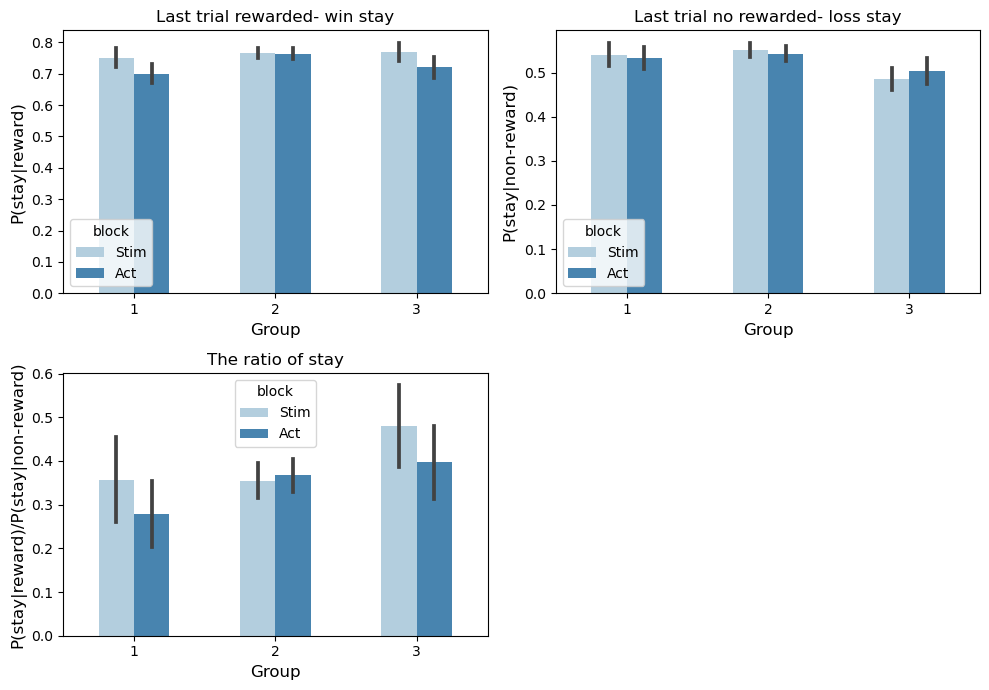

In [5]:
fig = plt.figure(figsize=(10,7), tight_layout=True)
row = 2
column = 2

# Win stay
fig.add_subplot(row, column, 1)
sns.barplot(data = df_win_loss, x='group', y='win_stay', hue='block',  width=.5, errorbar="se", palette = 'Blues')
plt.title('Last trial rewarded- win stay', fontsize='12')
plt.xlabel('Group', fontsize='12')
plt.ylabel('P(stay|reward)', fontsize='12')

# Loss stay
fig.add_subplot(row, column, 2)
sns.barplot(data = df_win_loss, x='group', y='loss_stay', hue='block',  width=.5, errorbar="se", palette = 'Blues')
plt.title('Last trial no rewarded- loss stay', fontsize='12')
plt.xlabel('Group', fontsize='12')
plt.ylabel('P(stay|non-reward)', fontsize='12')

# log stay
fig.add_subplot(row, column, 3)
sns.barplot(data = df_win_loss, x='group', y='log_stay', hue='block',  width=.5, errorbar="se", palette = 'Blues')
plt.title('The ratio of stay', fontsize='12')
plt.xlabel('Group', fontsize='12')
plt.ylabel('P(stay|reward)/P(stay|non-reward)', fontsize='12')

 # Save
plt.savefig('../figures/Probability_win_stay_shift.png', dpi=300)


In [6]:
stats.ttest_rel(df_win_loss[df_win_loss['group']==1]['log_stay'],
df_win_loss[df_win_loss['group']==3]['log_stay'])

TtestResult(statistic=-2.1859753078121296, pvalue=0.03150309962318752, df=87)

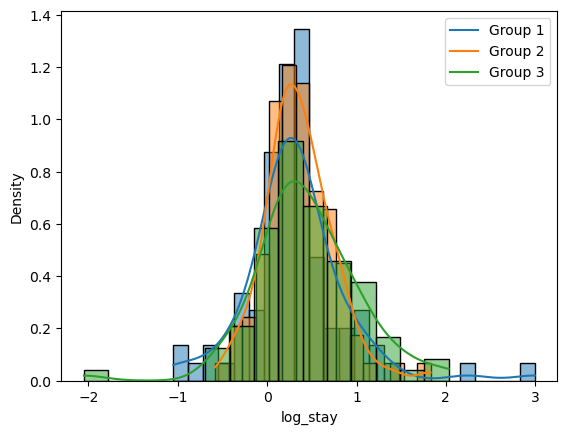

In [12]:
sns.histplot(df_win_loss[df_win_loss['group']==1]['log_stay'], kde=True, stat="density")
sns.histplot(df_win_loss[df_win_loss['group']==2]['log_stay'], kde=True, stat="density")
sns.histplot(df_win_loss[df_win_loss['group']==3]['log_stay'], kde=True, stat="density")
plt.legend(['Group 1', 'Group 2', 'Group 3'])

In [8]:
# anov = AnovaRM(data = df_win_loss[df_win_loss['group']!=2], depvar='log_stay', subject='sub_ID', within=['group', 'block'], between=None, aggregate_func='mean')
# print(anov.fit())

#import pingouin as pg
#pg.mixed_anova(dv='log_stay', between='group', within='block', subject='sub_ID', data=df_win_loss[df_win_loss['group']!=3])
